# Homework 02 Till Meineke

## Dataset

In this homework, we will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
```

The goal of this homework is to create a regression model for predicting the prices (column `'Final Price'`).

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

## EDA

* Load the data.

In [2]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv"

!wget $URL -O ./data/laptops.csv

df = pd.read_csv("./data/laptops.csv")
df.head(2)

--2024-09-30 17:55:50--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
Auflösen des Hostnamens raw.githubusercontent.com (raw.githubusercontent.com)… 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Verbindungsaufbau zu raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 298573 (292K) [text/plain]
Wird in »./data/laptops.csv« gespeichert.

./data/laptops.csv  100%[===================>] 291,58K  --.-KB/s    in 0,06s   

2024-09-30 17:55:51 (4,85 MB/s) - »./data/laptops.csv« gespeichert [298573/298573]



,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0


## Preparing the dataset

First, we'll normalize the names of the columns:

In [3]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

Now, instead of `'Final Price'`, we have `'final_price'`.

In [4]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [5]:
df_small = df[["ram", "storage", "screen", "final_price"]]
df_small.columns

Index(['ram', 'storage', 'screen', 'final_price'], dtype='object')

## EDA

* Look at the `final_price` variable. Does it have a long tail?

In [6]:
df_small.final_price.max()

7150.47

In [7]:
df_small.final_price.value_counts().sort_values(ascending=False)


final_price
999.00     27
1999.00    25
699.00     23
799.00     23
1599.00    21
           ..
1073.34     1
998.69      1
644.39      1
676.79      1
1699.99     1
Name: count, Length: 1440, dtype: int64

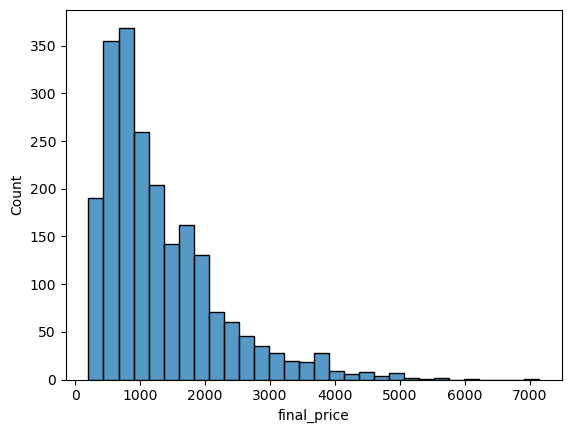

In [8]:
sns.histplot(df_small.final_price, bins=30);

Yes, the `final_price` variable has a long tail.

## Question 1

There's one feature with missing values. What is it?

In [9]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ram          2160 non-null   int64  
 1   storage      2160 non-null   int64  
 2   screen       2156 non-null   float64
 3   final_price  2160 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 67.6 KB


In [10]:
df_small.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [11]:
print("Screen missing values: ", df_small.screen.isnull().sum())

Screen missing values:  4


In [12]:
# Which column has missing values?
print(
    "Columns with missing values: ",
    df_small.columns[df_small.isnull().any()].tolist()[0],
)

Columns with missing values:  screen


`screen` is the column with missing values.

## Question 2

What's the median (50% percentile) for variable `'ram'`?

In [13]:
print(
    "The median (50% percentile) for variable 'ram' is: ",
    df_small["ram"].median(),
)

The median (50% percentile) for variable 'ram' is:  16.0


The median (50% percentile) for variable `ram` is:  16.0

## Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.

In [14]:
# from sklearn.utils import shuffle

# seed = 42

# # shuffle dataset
# df_small = shuffle(df_small, random_state=seed)

In [15]:
n = len(df_small)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df_small.iloc[idx]

* Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [16]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train["final_price"]
del df_val["final_price"]
del df_test["final_price"]

## Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!

In [18]:
mean_screen = df_train.screen.mean()
mean_screen

15.163534416086618

In [19]:
# fill missing values in `total_bedrooms` with the median value
X_train_mean = df_train.fillna(mean_screen).values
X_val_mean = df_val.fillna(mean_screen).values
X_test_mean = df_test.fillna(mean_screen).values

In [20]:
# fill missing values in `total_bedrooms` with 0
X_train_zero = df_train.fillna(0).values
X_val_zero = df_val.fillna(0).values
X_test_zero = df_test.fillna(0).values

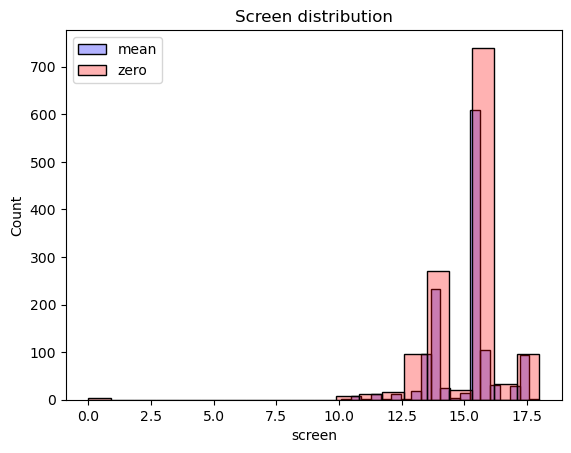

In [21]:
import seaborn as sns

sns.histplot(
    df_train.screen.fillna(mean_screen), bins=20, color="blue", alpha=0.3, label="mean"
)
sns.histplot(df_train.screen.fillna(0), bins=20, color="red", alpha=0.3, label="zero")
plt.legend()
plt.title("Screen distribution")
plt.show();

In [22]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [23]:
# Evaluate models
def rmse(y, y_pred):
    error = y - y_pred
    mse = (error**2).mean()
    return np.sqrt(mse)

In [24]:
w0_median, w_median = train_linear_regression(X_train_mean, y_train)
y_pred_median = w0_median + X_val_mean.dot(w_median)

In [25]:
w0_zero, w_zero = train_linear_regression(X_train_zero, y_train)
y_pred_zero = w0_zero + X_val_zero.dot(w_zero)

* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [26]:
print(
    "RMSE for model with median filled values:\t ", rmse(y_val, y_pred_median).round(2)
)
print("RMSE for model with 0 filled values:\t\t ", rmse(y_val, y_pred_zero).round(2))

RMSE for model with median filled values:	  600.27
RMSE for model with 0 filled values:		  597.36


- Option with 0 filled values gives better RMSE.

## Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of `r` from this list:`[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

In [27]:
def prepare_X(df):
    df = df.copy()
    df = df.fillna(0)

    X = df.values
    return X

In [28]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [29]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print("r: %06s - rmse: %0.2f" % (r, score))

r:      0 - rmse: 597.36
r:   0.01 - rmse: 597.36
r:    0.1 - rmse: 597.35
r:      1 - rmse: 597.21
r:      5 - rmse: 597.01
r:     10 - rmse: 597.06
r:    100 - rmse: 597.90


r = 5 gives the best RMSE. But it is not in the list of possible options. So, the best option from the list is r = 10.

## Question 5

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

In [30]:
def prepare_X(df, fillna_value):
    df = df.fillna(fillna_value)
    X = df.values
    return X

In [37]:
rmses = []

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    n = len(df_small)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_shuffled = df_small.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val :].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values


    del df_train["final_price"]
    del df_val["final_price"]
    del df_test["final_price"]

    X_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w_0 + X_val.dot(w)

    result = rmse(y_val, y_pred)

    rmses.append(result)

# Print results
print("Seed\t RMSE")
print("----\t ----")
for s, r in enumerate(rmses):
    print(f"{s}\t {r:.2f}")

Seed	 RMSE
----	 ----
0	 565.45
1	 636.80
2	 588.96
3	 597.81
4	 571.96
5	 573.24
6	 647.34
7	 550.44
8	 587.33
9	 576.10


* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

In [38]:
print("The value of std is: ", np.std(rmses).round(3))

The value of std is:  29.176


## Question 6

* Split the dataset like previously, use seed 9.

In [39]:
n = len(df_small)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_shuffled = df_small.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values


del df_train["final_price"]
del df_val["final_price"]
del df_test["final_price"]

* Combine train and validation datasets.

In [40]:
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

* Fill the missing values with 0 and train a model with `r=0.001`.

In [41]:
X_full_train = prepare_X(df_full_train, fillna_value=0)
y_full_train = np.concatenate([y_train, y_val])

w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

* What's the RMSE on the test dataset?

In [42]:
X_test = prepare_X(df_test, fillna_value=0)
y_pred = w_0 + X_test.dot(w)

result = rmse(y_test, y_pred)

print(f"The RMSE for the model is: ", result.round(2))

The RMSE for the model is:  608.61


## Homework URL

[Homework 02](https://github.com/TillMeineke/ML_Zoomcamp2024_hw/blob/main/02-regression/homework_02_till_meineke.ipynb)

## Learning in public links (optional) 

- [Learning of the week]((https://www.linkedin.com/pulse/learning-ml-zoomcamp-week-1-introduction-till-meineke-k05mc))

## Time spent on lectures (hours) (optional)

## Time spent on homework (hours) (optional)

## FAQ contribution (FAQ document, optional)